# Sust Global Zonal Stats Endpoint Visualization Example

## Intro

This notebook provides a quick walk through on how the Sust Global zonal dataset for Canada.

We use zonal climate risk stats from Sust Global to show case an example baseline and 2050 hazard data.

In [10]:
# Standard library
import os

# Third-party libraries
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import contextily as ctx
import folium
import cartopy.crs as ccrs
from shapely.geometry import Point, shape, Polygon
from IPython.display import display, HTML

In [11]:
SUST_API_KEY = os.environ.get("SUST_API_KEY") # Set the SUST_API_KEY environment variable with your api key
PROJECT = os.environ.get("SUST_PROJECT")      # Set the SUST_PROJECT environment variable with an enabled project

# Example endpoints for accessing zonal stats for the USA
endpoints = {
    "tessellation": f"https://explorer.sustglobal-staging.io/api/zonalstats?country_code=USA&admin_level=2&tessellated&rows=100",
    "aggregation"  : f"https://explorer.sustglobal-staging.io/api/zonalstats?country_code=USA&admin_level=2&rows=100",
}

## Helper Functions

In [3]:
def fetch_paginated_data(endpoint):
    """
    Fetches all pages of data from a paginated API endpoint using Sust Global authentication headers.

    This function sends repeated GET requests to a paginated endpoint, incrementing the page number
    until a non-200 HTTP response is received. All JSON response data is collected and returned as a list.

    Args:
        endpoint (str): The base URL of the API endpoint.

    Returns:
        list: A list containing the aggregated data from all successfully fetched pages.
    """
    
    # Set up authentication headers using API key and project identifier
    headers = {
        "X-SustGlobal-APIKey": SUST_API_KEY, 
        "X-SustGlobal-Project": PROJECT
    }
    
    page = 1     # Start with the first page
    buff = []    # Initialize a buffer to store all paginated results

    while True:
        # Construct the paginated URL using the current page number
        url = f'{endpoints[endpoint]}&page={page}'

        # Send GET request with headers
        response = requests.get(url, params={}, headers=headers)

        if response.status_code == 200:
            # If request is successful, append data to buffer
            buff += response.json()
            page += 1  # Move to the next page
        else:
            # If request fails (e.g., no more pages), return the accumulated data
            # print(f"Iterated {page} page(s)")
            return buff


def extract_summary_scores(gdf, scenario, hazard):
    """
    Extracts 30-year summary scores from a GeoDataFrame for a given scenario and hazard type.

    This function iterates through the provided GeoDataFrame `gdf`, accesses the nested 
    'scenario_analytics' field, and retrieves the `summary_score_30yr` value associated 
    with the specified climate scenario (e.g., 'ssp585') and hazard type (e.g., 'wildfire').

    Args:
        gdf (GeoDataFrame): The GeoPandas DataFrame containing a 'scenario_analytics' column.
        scenario (str): The climate scenario to filter by (e.g., 'ssp585').
        hazard (str): The hazard type to extract scores for (e.g., 'wildfire').

    Returns:
        list: A list of extracted summary scores for the specified scenario and hazard.
    """
    
    # Extract the summary scores for the given scenario and hazard
    scores = []
    
    for idx, row in gdf.iterrows():
        scenario_data = row['scenario_analytics']
        
        # Navigate through the nested structure, ex: ssp585 -> wildfire -> summary_score_30yr
        if scenario in scenario_data and hazard in scenario_data['ssp585']:
            score = scenario_data[scenario][hazard]['summary_score_30yr']
            scores.append(score)

    return scores


def extract_comparison_data(gdf, scenario, hazard, year):
    """
    Extracts baseline and future-year hazard indicator scores from a GeoDataFrame 
    for a specific climate scenario and hazard type.

    This function navigates the nested 'scenario_analytics' structure in each row of the GeoDataFrame 
    to retrieve the 'indicator_baseline' and a specified future-year indicator (e.g., 'indicator_2030') 
    for a given hazard under a given scenario (e.g., 'ssp585').

    Args:
        gdf (GeoDataFrame): A GeoPandas DataFrame containing a 'scenario_analytics' column with nested data.
        scenario (str): Climate scenario key (e.g., 'ssp585').
        hazard (str): Hazard type key (e.g., 'wildfire').
        year (int or str): Target year to extract indicator data for (e.g., 2030).

    Returns:
        tuple: A tuple of two lists:
            - baseline (list): Baseline hazard scores.
            - selected_year (list): Hazard scores for the specified year.
    """
    
    # Extract the baseline and provided year hazard scores for the given scenario and hazard
    baseline = []
    selected_year = []
    
    for idx, row in gdf.iterrows():
        scenario_data = row['scenario_analytics']
        
        # Navigate through the nested structure, ex: ssp585 -> wildfire -> indicator_baseline
        if scenario in scenario_data and hazard in scenario_data['ssp585']:
            indicator_baseline = scenario_data[scenario][hazard]['indicator_baseline']
            baseline.append(indicator_baseline)
            
            indicator_selected_year = scenario_data[scenario][hazard][f'indicator_{year}']
            selected_year.append(indicator_selected_year)

    return (baseline, selected_year)

## Loading the Data

Load the data from the Sust Global API using the endpoints for tessellated values and aggregated values.

In [4]:
tessellation = fetch_paginated_data("tessellation")
aggregation = fetch_paginated_data("aggregation")

Converts the aggregated data into a standard Pandas DataFrame (df), then transform it into a GeoPandas GeoDataFrame (gdf) by converting the 'geometry' field into geometric shapes using the shape() function from the shapely library. Also sets the coordinate reference system (CRS) to WGS84 (EPSG:4326).

If desired, swap between tessellation and aggregation values here.

In [5]:
df = pd.DataFrame(aggregation) # Optionally swap to df = pd.DataFrame(tessellation) for tessellated values
gdf = gpd.GeoDataFrame(df.copy().drop("geometry", axis=1), geometry=df.geometry.apply(shape), crs="EPSG:4326")

display(gdf.shape)
display(gdf.head())

(3196, 15)

,id,country,admin_processing_level,lng,lat,polygon,tessellated,admin0,admin1,admin2,admin3,admin4,labels,scenario_analytics,geometry
0,0,USA,2,-149.572986,62.315977,True,False,USA,Alaska,02170,,,"{'label:AFFGEOID': '0500000US02170', 'label:AL...",{'ssp245': {'cyclone': {'business_interruption...,"POLYGON ((-150.55172 61.29472, -150.53427 61.2..."
1,118,USA,2,-135.336255,59.562990,True,False,USA,Alaska,02230,,,"{'label:AFFGEOID': '0500000US02230', 'label:AL...",{'ssp245': {'cyclone': {'business_interruption...,"POLYGON ((-135.69827 59.73548, -135.71728 59.7..."
2,10,USA,2,-156.582888,20.863846,True,False,USA,Hawaii,15009,,,"{'label:AFFGEOID': '0500000US15009', 'label:CO...",{'ssp245': {'cyclone': {'business_interruption...,"MULTIPOLYGON (((-156.70729 20.91802, -156.7073..."
3,175,USA,2,-106.620188,52.798942,True,False,USA,Alaska,02016,,,"{'label:AFFGEOID': '0500000US02016', 'label:AL...",{'ssp245': {'cyclone': {'business_interruption...,"MULTIPOLYGON (((-176.67146 51.68116, -176.6736..."
4,126,USA,2,-164.027851,64.910956,True,False,USA,Alaska,02180,,,"{'label:AFFGEOID': '0500000US02180', 'label:AL...",{'ssp245': {'cyclone': {'business_interruption...,"MULTIPOLYGON (((-166.19764 64.48167, -166.1988..."


Extracts 30-year cyclone risk scores for the SSP585 climate scenario from a GeoDataFrame. The result is a modified dataset ready for analysis or visualization of cyclone hazard under the SSP585 scenario.

In [6]:
# Extract cyclone summary data for the SSP5-8.5 scenario
# `extract_summary_scores` returns a list with the scores
cyclone_scores = extract_summary_scores(gdf, "ssp585", "cyclone")
gdf_plotme = gdf.copy()
gdf_plotme['Cyclone_Score_SSP585'] = cyclone_scores

Create a map visualization using Matplotlib and GeoPandas. First, plot the GeoDataFrame, coloring regions based on the 'Cyclone_Score_SSP585' column and including a legend. The plot’s view is limited to a specific geographic region by setting longitude (x-axis) from -180 to -50 and latitude (y-axis) from 10 to 80.

(10.0, 80.0)

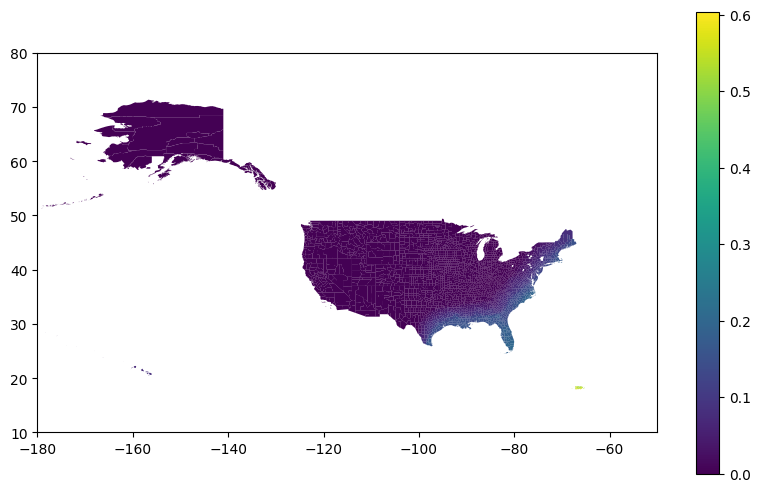

In [7]:
# Create a plot layout and select the column to display
fig, ax = plt.subplots(figsize=(10, 6))
gdf_plotme.plot(column='Cyclone_Score_SSP585', ax=ax, legend=True)

ax.set_xlim(-180, -50) # Restrict longitude range (x-axis)
ax.set_ylim(10, 80)    # Restrict latitudinal range (y-axis)

## Visualizing Change in Risk Over Time

Extracts baseline and 2050 risk scores for the SSP585 climate scenario from a GeoDataFrame. The result is a modified dataset ready for analysis or visualization of wildfire hazard under the SSP585 scenario.

In [8]:
# Extract wildfire data for the SSP5-8.5 scenario in the year 2050
# `extract_comparison_data` returns a tuple with baseline and 2050 data
comparison_data = extract_comparison_data(gdf_plotme, "ssp585", "wildfire", 2050)

wildfire_baseline = comparison_data[0] # Assign the baseline wildfire data (likely historical or present-day values)
wildfire_2050 = comparison_data[1]     # Assign the projected wildfire data for the year 2050 under SSP5-8.5

# Add the baseline and 2050 wildfire data to the GeoDataFrame as a new column
gdf_plotme['Wildfire_Baseline_SSP585'] = wildfire_baseline
gdf_plotme['Wildfire_2050_SSP585'] = wildfire_2050

This code creates side-by-side maps showing baseline and projected 2050 wildfire risk under the SSP5-8.5 scenario using Cartopy and GeoPandas. It plots spatial data with a consistent color scheme and custom classification bins to visualize wildfire intensity. This enables a clear visual comparison of how wildfire risk may change over time.

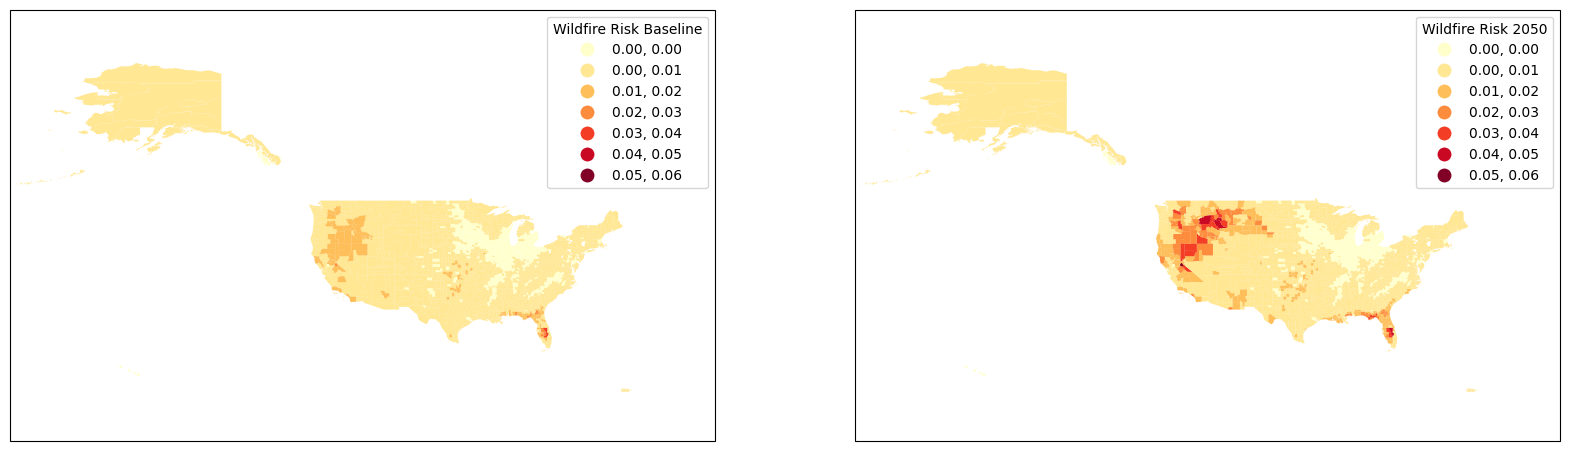

In [9]:
# Create a plot layout with cartopy projection 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot polygons with color fill based on a column, e.g., "Wildfire_Baseline_SSP585"
gdf_plotme.plot(column="Wildfire_Baseline_SSP585", 
               cmap="YlOrRd", 
               legend=True, 
               ax=ax1, 
               scheme='UserDefined',
               classification_kwds={'bins': [0,0.01,0.02,0.03,0.04,0.05,0.06], 'lowest': 0}, # Manually set the legend
               transform=ccrs.PlateCarree()) 

# Set the map view (longitude and latitude bounds) using Plate Carree projection
# Longitude: -180 to -50, Latitude: 10 to 80 — focuses on North and Central America
ax1.set_extent([-180, -50, 10, 80], crs=ccrs.PlateCarree())

# Create a title
leg1 = ax1.get_legend()
leg1.set_title(f"Wildfire Risk Baseline")

# Plot polygons for comparison with color fill based on a column, e.g., "Wildfire_2050_SSP585"
gdf_plotme.plot(column="Wildfire_2050_SSP585", 
               cmap="YlOrRd", 
               legend=True,
               ax=ax2, 
               scheme='UserDefined',
               classification_kwds={'bins': [0,0.01,0.02,0.03,0.04,0.05,0.06], 'lowest': 0}, # Manually set the legend
               transform=ccrs.PlateCarree()) 

# Set the map view (longitude and latitude bounds) using Plate Carree projection
# Longitude: -180 to -50, Latitude: 10 to 80 — focuses on North and Central America
ax2.set_extent([-180, -50, 10, 80], crs=ccrs.PlateCarree())

# Create a title
leg2 = ax2.get_legend()
leg2.set_title(f"Wildfire Risk 2050")